In [1]:
#Import Packages

from typing import Iterator, List, Union, Tuple
from datetime import datetime
from time import strftime
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
from tensorflow import Tensor
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, History
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import plot_model

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

C:\Users\illew\anaconda3\envs\tf-gpu-hardness\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


2.3.0
Num GPUs Available:  1


       sample  hardness                        image_location
0           0  4.298459  ./Augmented_Images_StdSize_PNG/0.png
1           1  3.651776  ./Augmented_Images_StdSize_PNG/1.png
2           2  5.292030  ./Augmented_Images_StdSize_PNG/2.png
3           3  5.529775  ./Augmented_Images_StdSize_PNG/3.png
4           4  5.152281  ./Augmented_Images_StdSize_PNG/4.png
...       ...       ...                                   ...
22725     329  6.100000     ./testdata_0425/images/6.1_21.png
22726     330  6.100000     ./testdata_0425/images/6.1_22.png
22727     331  6.100000     ./testdata_0425/images/6.1_23.png
22728     332  6.100000     ./testdata_0425/images/6.1_24.png
22729     333  6.100000     ./testdata_0425/images/6.1_25.png

[22730 rows x 3 columns]


Text(0, 0.5, 'Count')

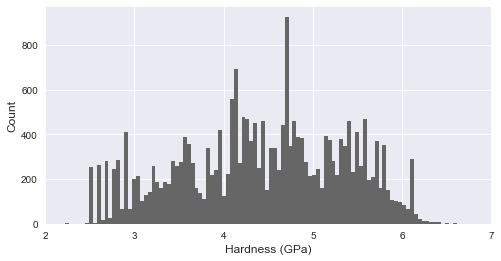

In [2]:
#Load Dataset

stamp = '03_11_15_55'
df = pd.read_csv ('Dataset_Collated_'+stamp+'.csv')
print(df)

#Visualize Data Labels

sns.set_style('darkgrid')
plt.figure(figsize=(8,4))
plt.hist(df["hardness"], 100, color='0.4', linewidth=0)
plt.axis(xmin=2, xmax=7)
plt.xlabel('Hardness (GPa)', fontsize=12)
plt.ylabel('Count', fontsize=12)

In [3]:
#Data Preprocessing Functions

def split_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Input a Pandas DataFrame, and split it into training, validatation, and testing DataFrames
    Parameters
    ----------
    df: pd.DataFrame
        Pandas DataFrame containing all your data.
    Returns
    ----------
    Union[pd.DataFrame, pd.DataFrame, pd.DataFrame]
    """
    train,val = train_test_split(df, test_size=0.2, random_state=1) 
    train,test = train_test_split(train, test_size=0.125, random_state=1)   
    print("shape train: ", train.shape)
    print("shape val: ", val.shape)
    print("shape test: ", test.shape)
    print("Descriptive statistics of train:")
    print(train.describe())
    return train, val, test

def get_mean_baseline(train: pd.DataFrame, val: pd.DataFrame) -> float:
    """Calculates mean squared error baseline by taking mean values of training data as prediction for validatation target feature
    Parameters
    ----------
    train: pd.DataFrame
        Pandas DataFrame containing Training data
    val: pd.DataFrame
        Pandas DataFrame containing Validation data
    Returns
    ----------
    float
        MSE value
    """
    y_hat=train["hardness"].mean()
    val["y_hat"]=y_hat
    mse = MeanSquaredError()
    mse = mse(val["hardness"],val["y_hat"]).numpy()
    mape = MeanAbsolutePercentageError()
    mape = mape(val["hardness"],val["y_hat"]).numpy()
    
    print(mse)
    print("mean baseline MSE: ", mse)
    return mse

def visualize_augmentation(data_generator: tf.keras.preprocessing.image.ImageDataGenerator, df: pd.DataFrame):
    """Visualizes the keras augmentations with matplotlib in 3x3 grid, part of create_generators()
    Parameters
    ----------
    data_generator: Iterator
        the keras data generator of training data
    df: pd.DataFrame
        the Pandas DataFrame containing training data
    """
    #Create a small data frame with one image
    series = df.iloc[2]
    df_augmentation_visualization = pd.concat([series,series],axis=1).transpose()
    
    iterator_visualizations = data_generator.flow_from_dataframe(
        dataframe=df_augmentation_visualization,
        x_col="image_location",
        y_col="hardness",
        class_mode="raw",
        target_size=(200,200),
        batch_size=1,
    )
    
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        batch=next(iterator_visualizations)
        img=batch[0]
        img=img[0,:,:,:]
        plt.imshow(img)
    plt.show()
    plt.close()
    
def create_generators(df: pd.DataFrame, train: pd.DataFrame, val: pd.DataFrame, test: pd.DataFrame, visualize_augmentations: bool) -> Tuple[Iterator, Iterator, Iterator]:
    """Accepts four Pandas DataFrames: full data, training, validation, and test DataFrames
    Creates and returns keras ImageDataGenerators. The function also visualizes the augmentations of ImageDataGenerators
    Parameters
    ----------
    df: pd.DataFrame
        DataFrame with all your data
    train: pd.DataFrame
        Training Data
    val: pd.DataFrame
        Validation Data
    test: pd.DataFrame
    Returns
    ----------
    Tuple[Iterator, Iterator, Iterator]
        keras ImageDataGenerators used for training, validating, and testing models.
    """
    #Creating ImageDataGenerator with multiple image augmentations for training
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0/255, 
#         brightness_range=[0.5,2.0],
        zoom_range=[0.5,1.0],
        horizontal_flip=True,
        vertical_flip=True,
    ) 
    validation_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
    
    if visualize_augmentations == True:
        visualize_augmentation(train_generator, df)
   
    #This is what defines the data "x_col" and its labels "y_col"
    train_generator=train_generator.flow_from_dataframe(
        dataframe=train,
        x_col="image_location",
        y_col="hardness",
        class_mode="raw",
        target_size=(200,200),
        batch_size=32,
    )
    
    validation_generator=validation_generator.flow_from_dataframe(
        dataframe=val,
        x_col="image_location",
        y_col="hardness",
        class_mode="raw",
        target_size=(200,200),
        batch_size=32,
    )

    test_generator=test_generator.flow_from_dataframe(
        dataframe=test,
        x_col="image_location",
        y_col="hardness",
        class_mode="raw",
        target_size=(200,200),
        batch_size=32,
    )
    return train_generator, validation_generator, test_generator

shape train:  (15911, 3)
shape val:  (4546, 3)
shape test:  (2273, 3)
Descriptive statistics of train:
             sample      hardness
count  15911.000000  15911.000000
mean      47.673622      4.421732
std       66.987943      0.921652
min        0.000000      2.227496
25%        8.000000      3.722293
50%       16.000000      4.461158
75%       64.000000      5.174924
max      333.000000      6.611892
0.8536134362220764
mean baseline MSE:  0.8536134362220764
Found 2 validated image filenames.


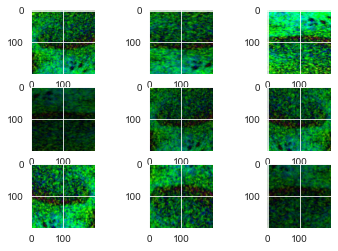

Found 15911 validated image filenames.
Found 4546 validated image filenames.
Found 2273 validated image filenames.


In [4]:
#Split the data
train, val, test = split_data(df)
mean_baseline=get_mean_baseline(train,val)

#Creating ImageDataGeneratorsto with augmentations to input dataset 
train_generator, validation_generator, test_generator = create_generators(df=df,train=train,val=val,test=test, visualize_augmentations=True)


In [5]:
#Model Functions

def get_callbacks(model_name: str) -> List[Union[TensorBoard, EarlyStopping, ModelCheckpoint]]:
    
    """Accepts the model name as a string and returns multiple callbacks for training the keras model
    Parameters
    ----------
    model_name: str
        The model name as a string
    Returns
    ----------
    List[Union[TensorBoard, EarlyStopping, ModelCheckpoint]]
        A list of multiple keras callbacks
    """
    #Create a folder for each model labelled with model name and date
    logdir = ("logs/scalars/"+model_name+"_"+datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(log_dir=logdir)
    
    early_stopping_callback = EarlyStopping(
        monitor="val_loss",
        min_delta=1, #model should improve by at least this much %
        patience=100, #number of epochs with improvements worse than min_delta before stopping
        verbose=2,
        mode="min",
        restore_best_weights=True,
    )
    
    model_checkpoint_callback = ModelCheckpoint(
        "./data/models/"+model_name,
        monitor="val_loss",
        verbose=0,
        save_best_only=True, #save the best model
        mode="min",
        save_freq="epoch",
    )
    
    return [tensorboard_callback, early_stopping_callback, model_checkpoint_callback]
    

def run_model(
    model_name: str,
    model_function: Model,
    lr: float,
    train_generator: Iterator,
    validation_generator: Iterator,
    test_generator: Iterator,
) -> History:
    
    """ This function runs a keras model with the Ranger optimizer and multiple callbacks. 
    The model is evaluated within training through the validation generator, 
    and afterwards one final time with the test generator
    
    Parameters
    ----------
    model_name: str
        The name of the model as a string
    model_function: Model
        Keras model function
    lr: float
        Learning rate
    train_generator: Iterator
        keras ImageDataGenerators for the training data.
    validation_generator: Iterator
        keras ImageDataGenerators for the validation data.
    test_generator: Iterator
        keras ImageDataGenerators for the test data.
        
    Returns
    ----------
    History
        The history of the keras model as a History object. 
    """
    
    callbacks = get_callbacks(model_name)
    model = model_function
    model.summary()
    plot_model(model, to_file=model_name+".jpg", show_shapes=True)
    
    radam = tfa.optimizers.RectifiedAdam(learning_rate=lr)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    optimizer = ranger
    
    model.compile(
        optimizer=optimizer, 
        loss=tf.keras.losses.MeanSquaredError(), 
    )
    
    history = model.fit(
        train_generator,
        epochs=240,
        validation_data=validation_generator,
        callbacks=callbacks,
        workers=6
    )
    
    model.evaluate(
        test_generator,
        callbacks=callbacks
    )

    return history


def plot_results(model_history_res_cnn: History, mean_baseline: float, stamp: str):

    """This function uses seaborn with matplotlib to plot training and validation losses in a sns.relplot()
    The mean baseline is plotted as a horizontal dotted line
    
    Parameters
    ----------
    model_history_res_cnn: History
        keras History of the model.fit() method
    mean_baseline: float
        result of the get_mean_baseline() function
    stamp: str
        time stamp for file name saving
    """
    #Create a dictionary for model history and loss (training and validation) type
    dict1 = {
        "MSE": model_history_res_cnn.history["loss"],
        "type": "training",
        "model": "res_cnn",
    }
    
    dict2 = {
        "MSE": model_history_res_cnn.history["val_loss"],
        "type": "validation",
        "model": "res_cnn",
    }
    
    #Convert dictionaries to pd.Series and concatenate them to a pd.DataFrame in the long format
    s1=pd.DataFrame(dict1)
    s2=pd.DataFrame(dict2)
    df_results=pd.concat([s1,s2],axis=0).reset_index()
    sns.set_style('ticks')
    
    grid=sns.relplot(data=df_results,x=df_results["index"],y="MSE",hue="type",kind="line",legend=False, aspect=1)
    grid.set(ylim=(0,2))
    grid.set(xlim=(0,100))
    
    for ax in grid.axes.flat:
        ax.axhline(y=mean_baseline, color="0.8", linestyle="dashed")
        ax.set_xlabel("Epoch", fontsize=16)
        ax.set_ylabel("Mean Squared Error", fontsize=16)
    labels=["training", "validation", "mean_baseline"]
    plt.legend(labels=labels)
    stamp = strftime("%m_%d_%H_%M")
    plt.savefig("training_validation_"+stamp+".png")
    plt.show()

In [6]:
#Defining the model structure

def relu_bn(inputs: Tensor)-> Tensor:
    relu=ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size = kernel_size, 
               strides = (1 if not downsample else 2),
               filters = filters,
               padding = "same"
              )(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size = kernel_size, 
               strides = 1,
               filters = filters,
               padding = "same"
              )(y)
    
    if downsample:
        x = Conv2D(kernel_size = 1,
                   strides = 2,
                   filters = filters,
                   padding = "same"                  
                  )(x)
    
    out = Add()([x, y])
    out = relu_bn(out)
    return out

def res_cnn():
    inputs = Input(shape=(200,200,3))
    num_filters = 32
    
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size = 3,
               strides = 1,
               filters = num_filters,
               padding = "same"
              )(t)
    t = relu_bn(t)
    
    num_blocks_list = [2,4,4,2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(1, activation="linear")(t)
    
    model = Model(inputs, outputs)
    
    return model

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 200, 200, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 200, 200, 32) 896         batch_normalization[0][0]        
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 200, 200, 32) 0           conv2d[0][0]                     
_______________________________________________________________________________________

Epoch 1/240
  1/498 [..............................] - ETA: 0s - loss: 22.7963WARNING:tensorflow:From C:\Users\illew\anaconda3\envs\tf-gpu-hardness\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
498/498 [==============================] - ETA: 0s - loss: 1.9270WARNING:tensorflow:From C:\Users\illew\anaconda3\envs\tf-gpu-hardness\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./data/models\res_cnn_

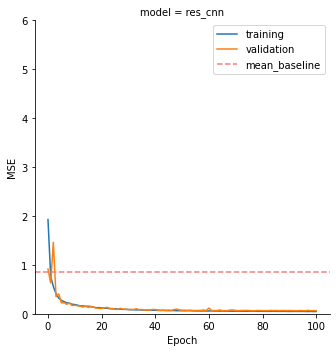

In [7]:
#Train the model
stamp = strftime("%m_%d_%H_%M")
res_cnn_history=run_model(
    model_name="res_cnn_"+stamp,
    model_function=res_cnn(), #define this above for the number and types of layers!
    lr=0.001,
    train_generator=train_generator,
    validation_generator=validation_generator,
    test_generator=test_generator,
)

plot_results(res_cnn_history, mean_baseline, stamp)

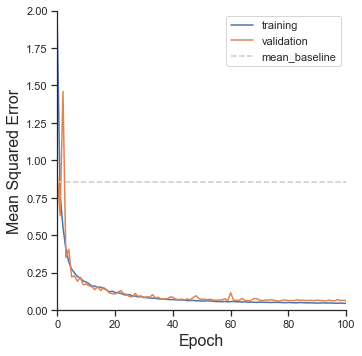

In [107]:
plot_results(res_cnn_history, mean_baseline, stamp)